In [1]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import and Install Dependencies

In [10]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from PIL import Image, ImageOps
import traceback
import time

# 2. Keypoints using MP Holistic

In [11]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [12]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [13]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [14]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [15]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():

#         # Read feed
#         ret, frame = cap.read()

#         # Make detections
#         image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Show to screen
#         cv2.imshow('OpenCV Feed', image)

#         # Break gracefully
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

# 3. Setup Folders for Collection

In [16]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')
LOG_PATH = os.path.join('./drive/MyDrive/PBL5/Logs/')

# Actions that we try to detect
actions = np.array(
[
    "Bye",
    "Eat",
    "Fine",
    "Good",
    "Hello",
    "I",
    "You",
    "Love",
    "None",
    "Read",
    "What",
    "Name",
    "Sleep",
    "Your"
  ]
    )

# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')



In [17]:
len(set(actions))

14

# 4. Extract Keypoint Values

In [18]:
import subprocess
list_num_frames  = []

for class_index, class_name in enumerate(actions):
    files_list = os.listdir(os.path.join(DATA_PATH, class_name))
    # Iterate through all the files present in the files list.
    for file_name in files_list:
        # print(file_name)
        # Get the complete video path.
        video_file_path = os.path.join(
            DATA_PATH, class_name, file_name)
        c = 'ffmpeg -y -i ' + video_file_path + ' -r 20 -c:v libx264 -preset ultrafast -movflags +faststart ' + video_file_path
        subprocess.call(c, shell=True)
        cap = cv2.VideoCapture(video_file_path)
        num_frames = 0
        while True:
            num_frames += 1
            rt, f = cap.read()
            if not rt:
                break
        list_num_frames.append(num_frames)
        cap.release()


(array([264., 213.,  32.,  14.,  16.,  48.,  70.,  20.,   1.,   1.]),
 array([  9. ,  22.6,  36.2,  49.8,  63.4,  77. ,  90.6, 104.2, 117.8,
        131.4, 145. ]),
 <BarContainer object of 10 artists>)

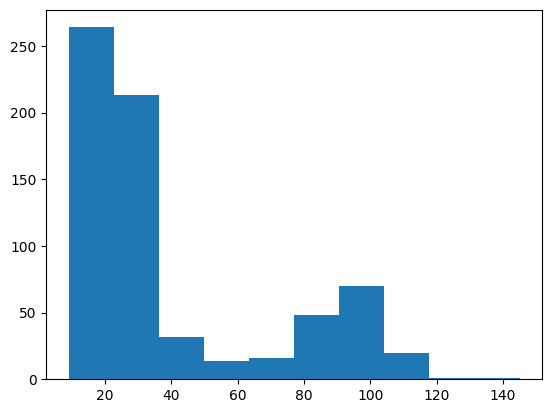

In [27]:
plt.hist(list_num_frames)

In [28]:
sum(np.array(list_num_frames) > 10)

673

In [32]:
sum(np.array(list_num_frames) > 12)

648

In [34]:
sequence_length = 12

In [35]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, lh, rh])

In [36]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [37]:
def resize_with_padding(img, expected_size):
    img = Image.fromarray(img)
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return np.array(ImageOps.expand(img, padding))

In [81]:
def frames_extraction(video_path, rev=False, angle=0, padding=False, skip_frames_window=0, skip_frames=0):
    video_reader = cv2.VideoCapture(video_path)
   
    # Danh sách chứa các frame sẽ lấy
    video_keypoints = []

    cap = cv2.VideoCapture(video_path)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame_counter in range(sequence_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES,
                    skip_frames + frame_counter * skip_frames_window)
            
            ret, frame = cap.read()
            if not ret:
                print('eror')
                continue

            if rev:
                frame = cv2.flip(frame, 1)
            if angle:
                frame = rotate_image(frame, angle=angle)
            if padding: 
                padding = np.random.randint(12, 17) / 10
                frame = resize_with_padding(frame, (int(frame.shape[1] * padding),int(frame.shape[0] * padding)))

            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)   

            keypoints = extract_keypoints(results)
            video_keypoints.append(keypoints)
    if len(video_keypoints) < sequence_length:
        return np.empty((0))
    video_keypoints = np.reshape(video_keypoints, (1, sequence_length, 300))
    return video_keypoints


# 5. Collect Keypoint Values for Training and Testing

In [92]:
import numpy as np

features = np.empty((0, sequence_length, 300))
labels = np.empty((0))

def dataOneFile(video_file_path, class_index, padding=False):
    global features
    global labels
    video_reader = cv2.VideoCapture(video_file_path)
    video_frames_count = 0
    s, f = video_reader.read()
    while s:
        s, f = video_reader.read()
        video_frames_count += 1
    video_reader.release()

    if video_frames_count < sequence_length:
        return []
    skip_frames = int(0.05 * video_frames_count)
    skip_frames_window = max(int((video_frames_count - skip_frames*2) /sequence_length), 1)

    video_keypoints = frames_extraction(video_file_path, padding=padding, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    # flip 
    video_keypoints = frames_extraction(video_file_path,  padding=padding, rev=True, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    # random rotate
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(10, 30), padding=padding, rev=True, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(-30, -10), padding=padding, rev=True, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    video_keypoints = frames_extraction(video_file_path, padding=padding, rev=False, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    # random rotate
    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(10, 30), padding=padding, rev=False, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

    video_keypoints = frames_extraction(video_file_path, angle=np.random.randint(-30, -10), padding=padding, rev=False, skip_frames_window=skip_frames_window, skip_frames=skip_frames)
    if video_keypoints.any():
        features = np.concatenate((features, video_keypoints), axis=0)
        labels = np.concatenate((labels, np.array([class_index])))

# Đảm bảo features và labels là mảng NumPy
features = np.array(features)
labels = np.array(labels)


In [93]:
def create_dataset():
    for class_index, class_name in enumerate(actions):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATA_PATH, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # print(file_name)
            try:
                video_file_path = os.path.join(
                    DATA_PATH, class_name, file_name)
                dataOneFile(video_file_path, class_index)
                dataOneFile(video_file_path, class_index, True)
                
            except Exception as e:
                print(e)
                traceback.print_stack()
                continue

        cv2.destroyAllWindows()
    return features, labels

In [94]:
time_start = time.time()
create_dataset()
# features = np.asarray(features)
# labels = np.array(labels)
np.savez_compressed(f'{DATA_PATH}/data_rich_full_padding_v2.npz', features=features, labels=labels)
time_end = time.time()


print('total time: ', time_end - time_start)

Extracting Data of Class: Bye
Extracting Data of Class: Eat
Extracting Data of Class: Fine
Extracting Data of Class: Good
Extracting Data of Class: Hello
Extracting Data of Class: I
Extracting Data of Class: You
Extracting Data of Class: Love
Extracting Data of Class: None
Extracting Data of Class: Read
Extracting Data of Class: What
Extracting Data of Class: Name
Extracting Data of Class: Sleep
Extracting Data of Class: Your
total time:  16956.75657248497


In [95]:
features.shape

(9065, 12, 300)

In [96]:
labels.shape

(9065,)

In [97]:
# data1 = np.load(f'{DATA_PATH}data_rich_full_padding1.npz')
# X1 = data1['features']
# labels1 = data1['labels']
# set(labels1)

In [98]:
# data2 = np.load(f'{DATA_PATH}data_rich_full_padding2.npz')
# X2 = data2['features']
# labels2 = data2['labels']
# set(labels2)

In [99]:
# data3 = np.load(f'{DATA_PATH}data_rich_full_padding3.npz')
# X3 = data3['features']
# labels3 = data3['labels'] 
# set(labels3)

In [ ]:
# x10 = X3[labels==10]
# labels10 = labels3[labels3==10]
# x10 = x10[:658]
# labels10 = labels10[:658]
# X3 = np.concatenate([X3, x10])
# labels3 = np.concatenate([labels3, labels10])


In [ ]:
# X = np.concatenate([X1, X2, X3])
# X.shape

(10220, 10, 300)

In [ ]:
# labels = np.concatenate([labels1, labels2, labels3])
# labels.shape

(10220,)

In [ ]:
# np.savez_compressed(f'{DATA_PATH}/data_rich_full_padding.npz', features=X, labels=labels)

# 6. Preprocess Data and Create Labels and Features

In [1]:
# Nếu chưa có thư viện thì run cell này
!pip install mediapipe
!pip install pandas
!pip install numpy
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 18.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [11]:
# Path for exported data, numpy arrays
# DATA_PATH = os.path.join('./Data')
DATA_PATH = os.path.join('./drive/MyDrive/PBL5/Data/')
log_dir = os.path.join(f'./drive/MyDrive/PBL5/Logs/{time.time()}')
checkpoint_filepath = f'./drive/MyDrive/PBL5/checkpoint/{time.time()}'


# Actions that we try to detect
actions = np.array(
['Bye','Eat', 'Fine', 'Good', 'Hello', 'I', 'You', 'Love', 'None', 'Read', 'What', 'Name', 'Sleep', 'Your']
    )
sequence_length = 12
# Path for exported data, numpy arrays
# DATASET_PATH = os.path.join('./Data')
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Bye': 0,
 'Eat': 1,
 'Fine': 2,
 'Good': 3,
 'Hello': 4,
 'I': 5,
 'You': 6,
 'Love': 7,
 'None': 8,
 'Read': 9,
 'What': 10,
 'Name': 11,
 'Sleep': 12,
 'Your': 13}

In [12]:
data = np.load(f'{DATA_PATH}/data_rich_full_padding_v2.npz')
X = data['features']
labels = data['labels']

In [13]:
X.shape

(9065, 12, 300)

In [14]:
y = to_categorical(labels).astype(int)

In [15]:
y.shape

(9065, 14)

In [16]:
X[0][0]

array([ 4.24572110e-01,  3.91099453e-01, -6.20995164e-01,  9.99823034e-01,
        4.48766142e-01,  3.35250854e-01, -5.96656501e-01,  9.99713480e-01,
        4.64428782e-01,  3.33132446e-01, -5.96550465e-01,  9.99755323e-01,
        4.75912452e-01,  3.32369387e-01, -5.96911073e-01,  9.99762595e-01,
        4.00368094e-01,  3.46564233e-01, -5.82663834e-01,  9.99599636e-01,
        3.85374457e-01,  3.49617004e-01, -5.82187533e-01,  9.99587834e-01,
        3.74935836e-01,  3.52028549e-01, -5.82514942e-01,  9.99527693e-01,
        5.01627088e-01,  3.48988414e-01, -3.70840609e-01,  9.99843359e-01,
        3.67427647e-01,  3.73072267e-01, -2.93987751e-01,  9.99661803e-01,
        4.55950230e-01,  4.34353441e-01, -5.34410000e-01,  9.99911666e-01,
        3.99439216e-01,  4.48770285e-01, -5.12012720e-01,  9.99860168e-01,
        6.50432348e-01,  5.84906161e-01, -2.66828209e-01,  9.99697089e-01,
        3.00807118e-01,  6.31576896e-01, -1.81701407e-01,  9.99257624e-01,
        7.37803280e-01,  

In [17]:
np.min(X[0])


-1.4836552143096924

In [ ]:
# Chuẩn hóa 
for idx, x in enumerate(X):
  X[idx] = x / np.max([np.abs(x), np.abs(x)])

In [18]:
for i in set(labels):
  print(i, len(y[labels==i]))

0.0 532
1.0 742
2.0 476
3.0 630
4.0 630
5.0 616
6.0 742
7.0 784
8.0 728
9.0 602
10.0 588
11.0 642
12.0 695
13.0 658


(array([106., 149.,  95., 126., 126., 123., 148., 157., 146., 120., 118.,
        128., 139., 132.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

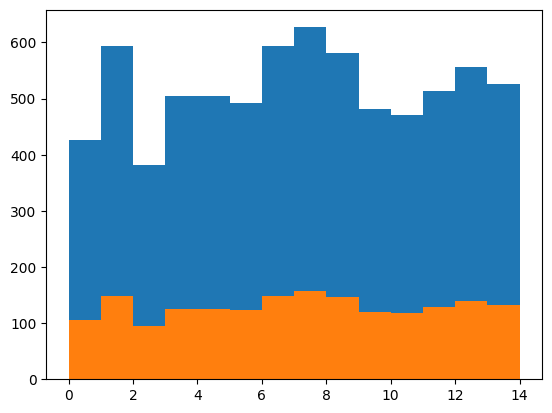

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for splitting
train_idx, test_idx = next(splitter.split(X, y))

# Split the data into train and test sets
X_train_val = X[train_idx]
X_test = X[test_idx]
y_train_val = y[train_idx]
y_test = y[test_idx]
plt.hist(np.argmax(y_train_val, 1), bins=np.arange(0,15), label=label_map)
plt.hist(np.argmax(y_test, 1), bins=np.arange(0,15), label=label_map)

(array([ 85., 119.,  76., 101., 101.,  99., 119., 126., 116.,  96.,  94.,
        103., 111., 105.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

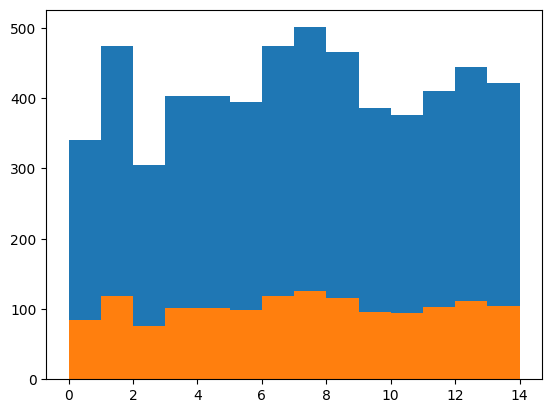

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for splitting
train_idx, val_idx = next(splitter2.split(X_train_val, y_train_val))

# Split the data into train and val sets
X_train = X_train_val[train_idx]
X_val = X_train_val[val_idx]
y_train = y_train_val[train_idx]
y_val = y_train_val[val_idx]
plt.hist(np.argmax(y_train, 1), bins=range(0,15), label=label_map)
plt.hist(np.argmax(y_val, 1), bins=range(0,15), label=label_map)

# 7. Build and Train LSTM Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import initializers
import tensorflow as tf
import time

In [22]:
# set Glorot initialization for all layers

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', kernel_initializer= initializers.he_normal(), input_shape=(sequence_length,X.shape[-1])))
model.add(LSTM(128, return_sequences=True, activation='relu', kernel_initializer= initializers.he_normal()))
model.add(LSTM(64, return_sequences=False, activation='relu', kernel_initializer= initializers.he_normal()))
model.add(Dense(64, activation='relu', kernel_initializer= initializers.he_normal()))
model.add(Dense(32, activation='relu', kernel_initializer= initializers.he_normal()))
model.add(Dense(actions.shape[0], activation='softmax', kernel_initializer= initializers.he_normal()))

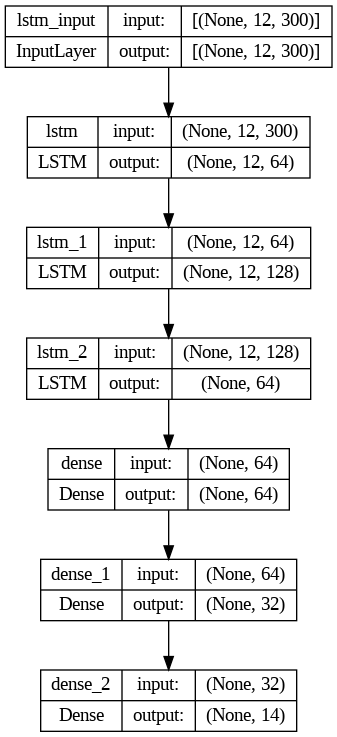

In [26]:
from keras.utils import plot_model

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 248,366
Trainable params: 248,366
Non-trai

In [8]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [24]:
time_start = time.time()
learning_rate = 0.001
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 2
    return lr

# Create a callback to use the scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=Adam(learning_rate=learning_rate, ), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


epoch = 300
batch_size = 4
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping_callback_acc = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

# model = tf.keras.models.load_model(path_weight)
model_history = model.fit(x = X_train, y = y_train, epochs = epoch, shuffle = True, validation_data=[X_val, y_val], batch_size=batch_size, callbacks = [early_stopping_callback_acc, tb_callback, model_checkpoint_callback, lr_scheduler])

path_weight =f'{DATA_PATH}/weight_rich_padding_bs{batch_size}_lr{learning_rate}_v2.h5'
model.save(path_weight)
time_end = time.time()
print(f'total time: {(time_start-time_end)/60}h')

Epoch 1/300
1451/1451 [==============================] - 131s 85ms/step - loss: 1.5082 - categorical_accuracy: 0.4935 - val_loss: 0.9117 - val_categorical_accuracy: 0.7023 - lr: 0.0010
Epoch 2/300
1451/1451 [==============================] - 123s 85ms/step - loss: 0.8414 - categorical_accuracy: 0.7107 - val_loss: 0.7089 - val_categorical_accuracy: 0.7726 - lr: 0.0010
Epoch 3/300
1451/1451 [==============================] - 119s 82ms/step - loss: 0.6601 - categorical_accuracy: 0.7773 - val_loss: 0.7229 - val_categorical_accuracy: 0.7547 - lr: 0.0010
Epoch 4/300
1451/1451 [==============================] - 123s 85ms/step - loss: 0.5422 - categorical_accuracy: 0.8205 - val_loss: 0.4567 - val_categorical_accuracy: 0.8442 - lr: 0.0010
Epoch 5/300
1451/1451 [==============================] - 125s 86ms/step - loss: 0.4596 - categorical_accuracy: 0.8524 - val_loss: 0.3768 - val_categorical_accuracy: 0.8766 - lr: 0.0010
Epoch 6/300
1451/1451 [==============================] - 125s 86ms/step - l

In [25]:

# path_weight = './weights_1681109498.3648455.h5'
# model = tf.keras.models.load_model(path_weight)
model.evaluate(X_test, y_test)

57/57 [==============================] - 0s 8ms/step - loss: 0.2117 - categorical_accuracy: 0.9415


[0.211740642786026, 0.9415333867073059]

# 10. Evaluation using Confusion Matrix and Accuracy

In [27]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, color_1='blue', color_2='red'):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, color_1, label = metric_name_1)
    plt.plot(epochs, metric_value_2, color_2, label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

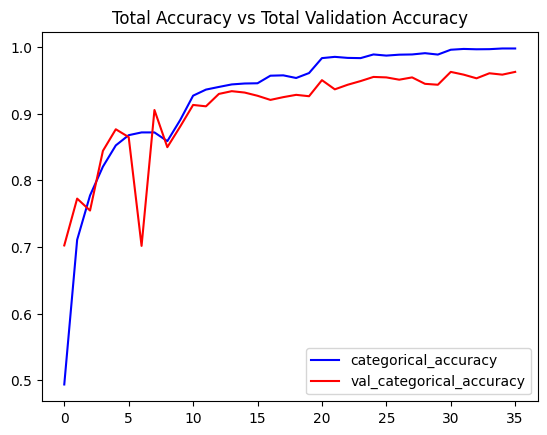

In [28]:
plot_metric(model_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

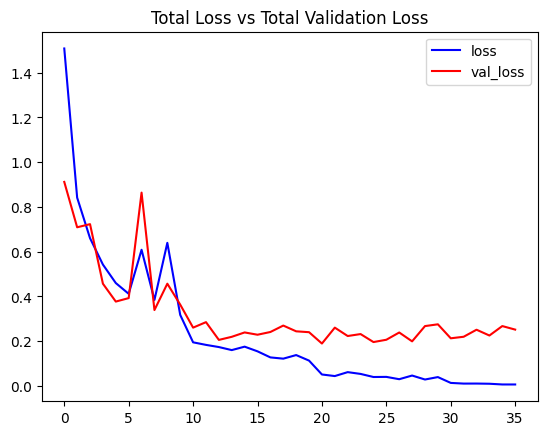

In [29]:
plot_metric(model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [30]:
model = tf.keras.models.load_model(path_weight)
yhat = model.predict(X_test)

57/57 [==============================] - 3s 21ms/step


In [31]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(y_true=ytrue, y_pred=yhat)


0.9415333701047987

<Axes: >

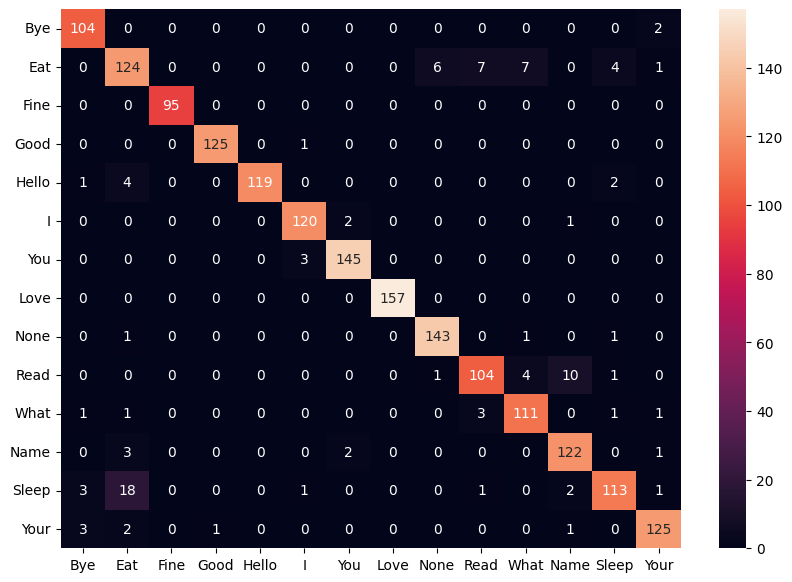

In [32]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
array = confusion_matrix(ytrue, yhat)
df_cm = pd.DataFrame(array, index = [i for i in actions],
                  columns = [i for i in actions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')
# dự đoán là dọc

# 11. Test in Real Time

In [ ]:
from scipy import stats
import threading
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # for num, prob in enumerate(res[6:]):
    #     cv2.rectangle(output_frame, (input_frame.shape[1]-120,60+num*40), (input_frame.shape[1]-120+int(prob*100), 90+num*40), colors[num%3], -1)
    #     cv2.putText(output_frame, actions[num+6], (input_frame.shape[1]-120, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# path_weight = './weights_1681109498.3648455.h5'
model = tf.keras.models.load_model(path_weight)

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        sequence = []


            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()